                        Project done by Michela Pirozzi MAT:732531 and Sara Ferioli MAT:733105

# LAB 3

## Goal

* Date le feature del dataset,  qualè la combinazione migliore che permette di avere un nuovo contratto (Es. INDETERMINATO) prima del covid? la combinazione di feature è la stessa anche dopo il covid?
* predirre numero di contratti

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import math
from sklearn import preprocessing
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt # data visualisation
import datetime as dt # working with time data
import warnings  
warnings.filterwarnings('ignore')

### Functions

In [3]:
# Method that allow to load ateco csv and prepare the data for the join
def addingAteco():
    df_ateco = pd.read_csv("ateco.csv")
    df_ateco.Descrizione_ateco.replace(r'^.* - ' , '',regex=True, inplace = True,)
    df_ateco = df_ateco.drop("_id",axis=1)
    df_ateco.rename(columns = {"Descrizione_ateco":"SETTOREECONOMICODETTAGLIO"}, inplace = True)
    df_ateco['SETTOREECONOMICODETTAGLIO'] = df_ateco['SETTOREECONOMICODETTAGLIO'].str.upper()
    df_ateco.drop_duplicates(subset="SETTOREECONOMICODETTAGLIO",keep="first",inplace=True)
    return df_ateco

### Import data and analysis

In [4]:
# Load the dataframe
attivati = pd.read_csv("Rapporti_di_lavoro_attivati.csv")

In [5]:
ateco = addingAteco()
ateco

,Codice_ateco,SETTOREECONOMICODETTAGLIO
0,01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
1,01.1,COLTIVAZIONE DI COLTURE AGRICOLE NON PERMANENTI
2,01.11,"COLTIVAZIONE DI CEREALI (ESCLUSO IL RISO), LEG..."
3,01.11.1,COLTIVAZIONE DI CEREALI (ESCLUSO IL RISO)
5,01.11.2,COLTIVAZIONE DI SEMI OLEOSI
...,...,...
3100,96.09.09,ALTRE ATTIVITÀ DI SERVIZI PER LA PERSONA NCA
3101,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3106,98,PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI P...
3107,98.1,PRODUZIONE DI BENI INDIFFERENZIATI PER USO PRO...


In [6]:
# Transformations of the strings in upper case, to make join
attivati['SETTOREECONOMICODETTAGLIO'] = attivati['SETTOREECONOMICODETTAGLIO'].str.upper()

In [7]:
# Retrieve only the year from the date 
attivati['DATA'] = pd.to_datetime(attivati['DATA'])
attivati ['ANNO'] = attivati.DATA.dt.year
attivati = attivati.drop(labels='DATA', axis=1)

In [8]:
# Join between the two DataFrames
join = pd.merge(attivati, ateco, on =['SETTOREECONOMICODETTAGLIO'], how='inner')
join

,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97
...,...,...,...,...,...,...,...,...,...,...
9329690,M,38,TRASPORTO MEDIANTE CONDOTTE DI LIQUIDI,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2020,49.50.2
9329691,F,40,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2021,93.19.91
9329692,M,28,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,LICENZA MEDIA,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,MONZA E BRIANZA,ITALIA,2012,93.19.91
9329693,F,25,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2018,93.19.91


In [9]:
# Obtain only the first two digits of the 'codice ateco' to understand the macro category
join.Codice_ateco.replace(r'^(..)\..*' , r'\1',regex=True, inplace = True,)
join

,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97
...,...,...,...,...,...,...,...,...,...,...
9329690,M,38,TRASPORTO MEDIANTE CONDOTTE DI LIQUIDI,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2020,49
9329691,F,40,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2021,93
9329692,M,28,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,LICENZA MEDIA,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,MONZA E BRIANZA,ITALIA,2012,93
9329693,F,25,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2018,93


In [10]:
# Extract macro category
join2 = pd.merge(join, ateco, on='Codice_ateco', how='inner')
join2

,GENERE,ETA,SETTOREECONOMICODETTAGLIO_x,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,INDUSTRIA DEL TABACCO,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO
9329691,M,35,INDUSTRIA DEL TABACCO,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO
9329692,M,27,INDUSTRIA DEL TABACCO,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO
9329693,M,37,INDUSTRIA DEL TABACCO,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO


In [11]:
# Delete the sub category
join2 = join2.drop(labels='SETTOREECONOMICODETTAGLIO_x', axis=1)

In [12]:
# Transformations of the strings in upper case, to make a match, without problem
join2['CONTRATTO']=join2['CONTRATTO'].str.upper()
join2

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y
0,F,60,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
1,F,33,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
2,F,45,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3,F,61,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
4,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO
9329691,M,35,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO
9329692,M,27,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO


In [13]:
join2.loc[join2['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == True,"CONTRATTO"]="INDETERMINATO"
join2.loc[join2['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == False,"CONTRATTO"]="NON INDETERMINATO"

# Create mapper
scale_mapper = {'NON INDETERMINATO':0, 'INDETERMINATO':1}

# Map feature values to scale
indeterminato=join2
indeterminato['CONTRATTO_transformed'] = indeterminato['CONTRATTO'].replace(scale_mapper)
indeterminato

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,CONTRATTO_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0


### Label Encoder

In [14]:
# Starting the procedure to encode the data
titolostudio = indeterminato.TITOLOSTUDIO.tolist()
modlavoro = indeterminato.MODALITALAVORO.tolist()
prov = indeterminato.PROVINCIAIMPRESA.tolist()
nazionalita = indeterminato.ITALIANO.tolist()
copia = indeterminato.copy()

In [15]:
# Instantiate labelencoder object for each column that we want to encode
le_titolostudio = LabelEncoder()
le_modlavoro = LabelEncoder()
le_prov = LabelEncoder()
le_nazionalita = LabelEncoder()

In [16]:
# Apply the label encoder to the dataset
le_titolostudio.fit(copia['TITOLOSTUDIO'])
le_modlavoro.fit(copia['MODALITALAVORO'])
le_prov.fit(copia['PROVINCIAIMPRESA'])
le_nazionalita.fit(copia['ITALIANO'])

LabelEncoder()

In [17]:
# Transform into integers
transformation_ts = le_titolostudio.transform(indeterminato['TITOLOSTUDIO']) 
transformation_ts

array([8, 8, 8, ..., 8, 0, 0])

In [18]:
# Try to invert a transformation using the object
list(le_titolostudio.inverse_transform([8]))

['NESSUN TITOLO DI STUDIO']

In [19]:
# Transform into integers
transformation_ml = le_modlavoro.transform(indeterminato['MODALITALAVORO']) 
transformation_prov = le_prov.transform(indeterminato['PROVINCIAIMPRESA']) 
transformation_nazion = le_nazionalita.transform(indeterminato['ITALIANO']) 

In [20]:
# Apply label encoder on categorical feature columns
copia['titolostudio_transformed'] = list(transformation_ts)
copia['modalitalavoro_transformed'] = list(transformation_ml)
copia['provincia_transformed'] = list(transformation_prov)
copia['nazionalita_transformed'] = list(transformation_nazion)
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89


### Encoding Manually Ordinal Categorical Features

In [21]:
# Create mapper
scale_mapper = {'M':0, 'F':1}

# Map feature values to scale
copia['genere_transformed'] = copia['GENERE'].replace(scale_mapper)
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188,1
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89,1
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [22]:
# Trasform the column in int type
copia['Codice_ateco']=copia.Codice_ateco.astype(int)

# We remove the outliers. 
copia = copia[copia['ETA']>=15]
copia = copia[copia['ETA']<100]
copia = copia[copia['ANNO']<2022]
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188,1
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89,1
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [23]:
# Drop the columns that have been transformed
transformed_indet = copia.drop(labels =['GENERE', 'TITOLOSTUDIO', 'MODALITALAVORO', 'PROVINCIAIMPRESA', 'ITALIANO', 'SETTOREECONOMICODETTAGLIO_y', 'CONTRATTO'], axis=1)
transformed_indet

,ETA,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,60,2020,97,0,8,4,0,188,1
1,33,2012,97,0,8,2,0,81,1
2,45,2019,97,0,8,4,0,89,1
3,61,2014,97,0,8,4,4,188,1
4,20,2014,97,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...
9329690,36,2012,12,0,0,5,0,89,0
9329691,35,2011,12,0,8,4,1,89,0
9329692,27,2009,12,0,8,4,7,89,0
9329693,37,2012,12,0,0,5,0,89,0


In [24]:
# Change the type of all column
transformed_indet['Codice_ateco'] = transformed_indet['Codice_ateco'].astype(str).astype(int)
transformed_indet.dtypes

ETA                           int64
ANNO                          int64
Codice_ateco                  int64
CONTRATTO_transformed         int64
titolostudio_transformed      int64
modalitalavoro_transformed    int64
provincia_transformed         int64
nazionalita_transformed       int64
genere_transformed            int64
dtype: object

In [25]:
transformed_indet

,ETA,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,60,2020,97,0,8,4,0,188,1
1,33,2012,97,0,8,2,0,81,1
2,45,2019,97,0,8,4,0,89,1
3,61,2014,97,0,8,4,4,188,1
4,20,2014,97,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...
9329690,36,2012,12,0,0,5,0,89,0
9329691,35,2011,12,0,8,4,1,89,0
9329692,27,2009,12,0,8,4,7,89,0
9329693,37,2012,12,0,0,5,0,89,0


### Group by features given as input

The idea is to consider non-modifiable features for each person (gender, age, and nationality) and to target an indeterminated contract. 
The result, will be to get the best combination of all other features to get the contract.

In [26]:
# Function to transform the columns ETA, nazionalita_transformed, genere_transformed in a unique column
# with the format: "ETA - nazionalita_transformed - genere_transformed"
# syntax:
# df: Dataframe
# column: column name of the new column
def trasformed_input(df,column):
    df[column] = df["ETA"].apply(str) + " - " + df["genere_transformed"].apply(str)+ " - " + df["nazionalita_transformed"].apply(str)
    return df.drop(labels=['ETA','nazionalita_transformed','genere_transformed'], axis=1)

In [27]:
# Function to retrive the original data from the trasformed ones
# syntax:
# df: Dataframe
# column: column name of the trasformed column
def inverse_trasformed_input(df,column):
    if type(df) is str:
        eta,genere,nazion=df.split(" - ")
        print("età: "+eta+" genere: "+genere+" nazion: "+nazion)
        return eta,genere,nazion
    
    df[['ETA','genere_transformed','nazionalita_transformed']] = df[column].str.split(" - ",expand=True,)
    return df.drop(labels =[column], axis=1)

In [28]:
# Function to retrive the original data from the trasformed ones
# syntax:
# value: trasfomed value
# return 'M' if value is 0 otherwise 'F'
def gender(value):
    if value=='0':
        return 'M'
    else:
        return 'F'

In [29]:
# Encoding of the input
transformed_indet=trasformed_input(transformed_indet,'Input')
transformed_indet

,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,Input
0,2020,97,0,8,4,0,60 - 1 - 188
1,2012,97,0,8,2,0,33 - 1 - 81
2,2019,97,0,8,4,0,45 - 1 - 89
3,2014,97,0,8,4,4,61 - 1 - 188
4,2014,97,0,8,2,4,20 - 1 - 89
...,...,...,...,...,...,...,...
9329690,2012,12,0,0,5,0,36 - 0 - 89
9329691,2011,12,0,8,4,1,35 - 0 - 89
9329692,2009,12,0,8,4,7,27 - 0 - 89
9329693,2012,12,0,0,5,0,37 - 0 - 89


In [30]:
# Check if the decoding of the input is correct
transformed_indet=inverse_trasformed_input(transformed_indet,'Input')
transformed_indet

,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,ETA,genere_transformed,nazionalita_transformed
0,2020,97,0,8,4,0,60,1,188
1,2012,97,0,8,2,0,33,1,81
2,2019,97,0,8,4,0,45,1,89
3,2014,97,0,8,4,4,61,1,188
4,2014,97,0,8,2,4,20,1,89
...,...,...,...,...,...,...,...,...,...
9329690,2012,12,0,0,5,0,36,0,89
9329691,2011,12,0,8,4,1,35,0,89
9329692,2009,12,0,8,4,7,27,0,89
9329693,2012,12,0,0,5,0,37,0,89


In [31]:
# Encoding of the input
transformed_indet = trasformed_input(transformed_indet,'Input')
transformed_indet

,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,Input
0,2020,97,0,8,4,0,60 - 1 - 188
1,2012,97,0,8,2,0,33 - 1 - 81
2,2019,97,0,8,4,0,45 - 1 - 89
3,2014,97,0,8,4,4,61 - 1 - 188
4,2014,97,0,8,2,4,20 - 1 - 89
...,...,...,...,...,...,...,...
9329690,2012,12,0,0,5,0,36 - 0 - 89
9329691,2011,12,0,8,4,1,35 - 0 - 89
9329692,2009,12,0,8,4,7,27 - 0 - 89
9329693,2012,12,0,0,5,0,37 - 0 - 89


In [32]:
# With LabelEncoder we encode the input column
copia = transformed_indet.copy()
le_input = LabelEncoder()
le_input.fit(copia['Input'])
transformation_input = le_input.transform(transformed_indet['Input']) 
copia['Input_transformed'] = list(transformation_input)
copia=copia.drop(labels =['Input'], axis=1)
copia

,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,Input_transformed
0,2020,97,0,8,4,0,11758
1,2012,97,0,8,2,0,5036
2,2019,97,0,8,4,0,8418
3,2014,97,0,8,4,4,11929
4,2014,97,0,8,2,4,1106
...,...,...,...,...,...,...,...
9329690,2012,12,0,0,5,0,5786
9329691,2011,12,0,8,4,1,5498
9329692,2009,12,0,8,4,7,3060
9329693,2012,12,0,0,5,0,6064


### Bilanciamento

In [33]:
copia["CONTRATTO_transformed"].value_counts(normalize=True)

0    0.854897
1    0.145103
Name: CONTRATTO_transformed, dtype: float64

Non è bilanciato

#### Undersampling randomico

Undersampling perchè diamo più importanza all'INDETERMINATO che ha meno occorrenze

In [34]:
copia[copia["CONTRATTO_transformed"]==1].count()

ANNO                          1352019
Codice_ateco                  1352019
CONTRATTO_transformed         1352019
titolostudio_transformed      1352019
modalitalavoro_transformed    1352019
provincia_transformed         1352019
Input_transformed             1352019
dtype: int64

In [35]:
copia[copia["CONTRATTO_transformed"]==0].count()

ANNO                          7965640
Codice_ateco                  7965640
CONTRATTO_transformed         7965640
titolostudio_transformed      7965640
modalitalavoro_transformed    7965640
provincia_transformed         7965640
Input_transformed             7965640
dtype: int64

In [36]:
data_0 = copia[copia["CONTRATTO_transformed"]==0].sample(n=1352019,random_state=16)
data_1 = copia[copia["CONTRATTO_transformed"]==1]
balanced = data_0.append(data_1)
balanced

,ANNO,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,Input_transformed
6304256,2015,22,0,8,2,1,1253
6515787,2014,38,0,6,2,6,8012
5627088,2013,96,0,6,2,7,970
2038440,2012,56,0,0,5,0,4792
5870029,2021,87,0,0,2,11,3825
...,...,...,...,...,...,...,...
9329673,2019,6,1,4,4,0,2907
9329675,2014,6,1,4,4,7,3520
9329683,2009,6,1,6,4,7,4892
9329685,2021,6,1,4,4,7,5198


In [37]:
balanced["CONTRATTO_transformed"].value_counts(normalize=True)

0    0.5
1    0.5
Name: CONTRATTO_transformed, dtype: float64

### Cross Validation

### Decision Tree

### ARIMA

In [40]:
bal1 = balanced.copy()
bal1.loc[:,"ANNO"] = pd.to_datetime(bal1.loc[:,"ANNO"].astype(str))
bal1.loc[:,"Anno"] = bal1["ANNO"].dt.year
bal1 = bal1.drop(columns = ['ANNO'])
bal1 = bal1 [['Anno', 'Codice_ateco', 'CONTRATTO_transformed', 'titolostudio_transformed', 
            'modalitalavoro_transformed', 'provincia_transformed', 'Input_transformed']]
bal1 = bal1[bal1['Anno']> 2006]
bal1

,Anno,Codice_ateco,CONTRATTO_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,Input_transformed
6304256,2015,22,0,8,2,1,1253
6515787,2014,38,0,6,2,6,8012
5627088,2013,96,0,6,2,7,970
2038440,2012,56,0,0,5,0,4792
5870029,2021,87,0,0,2,11,3825
...,...,...,...,...,...,...,...
9329673,2019,6,1,4,4,0,2907
9329675,2014,6,1,4,4,7,3520
9329683,2009,6,1,6,4,7,4892
9329685,2021,6,1,4,4,7,5198


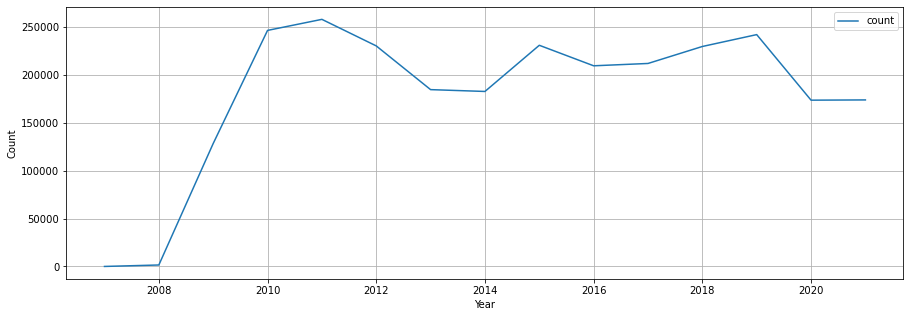

In [41]:
bal2 = bal1.groupby("Anno").size().reset_index(name='count')
bal2 = bal2.set_index('Anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
bal2.plot(ax=ax1)
ax1.set_xlabel("Year")
ax1.set_ylabel("Count")
plt.grid(True)

In [42]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(bal2["count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -6.923985
p-value: 0.000000


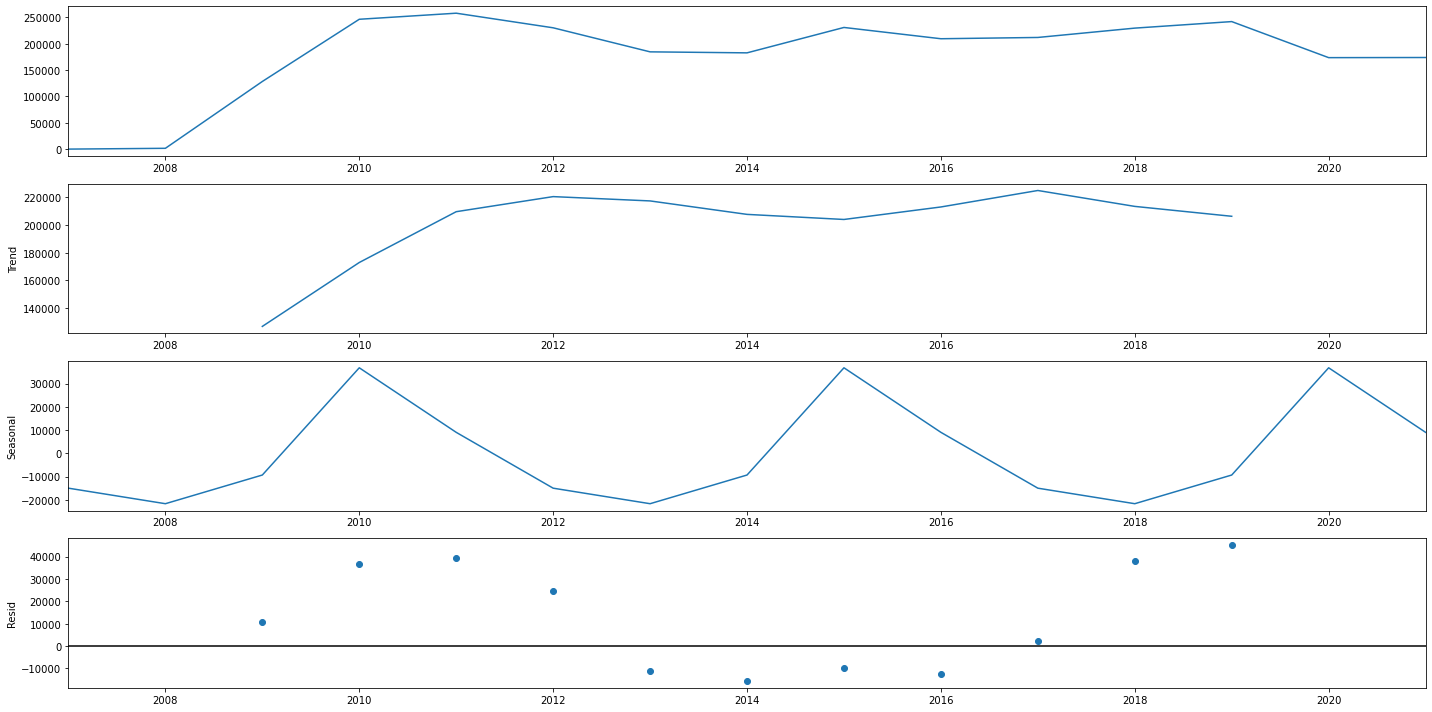

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(bal2, model="additive", period=5)
add = decomposed_add.plot()
plt.show()

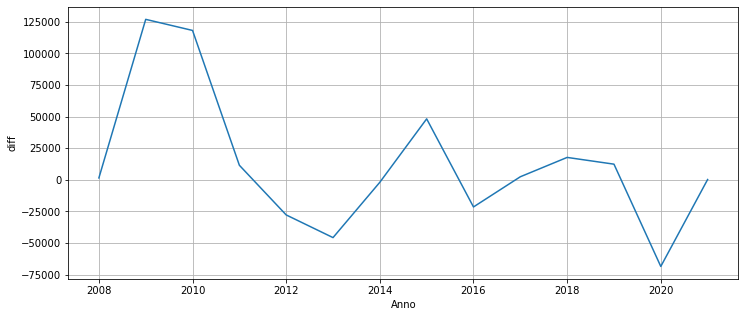

In [44]:
bal_diff = bal2.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = bal_diff["count"].plot()
ax1.set_xlabel("Anno")
ax1.set_ylabel("diff")
plt.grid(True)
plt.show()

In [45]:
results = adfuller(bal_diff["count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -3.446804
p-value: 0.009463


In [46]:
results = adfuller(bal2.diff().diff().dropna()["count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -3.781481
P-value of a test is: 0.003102570579975607


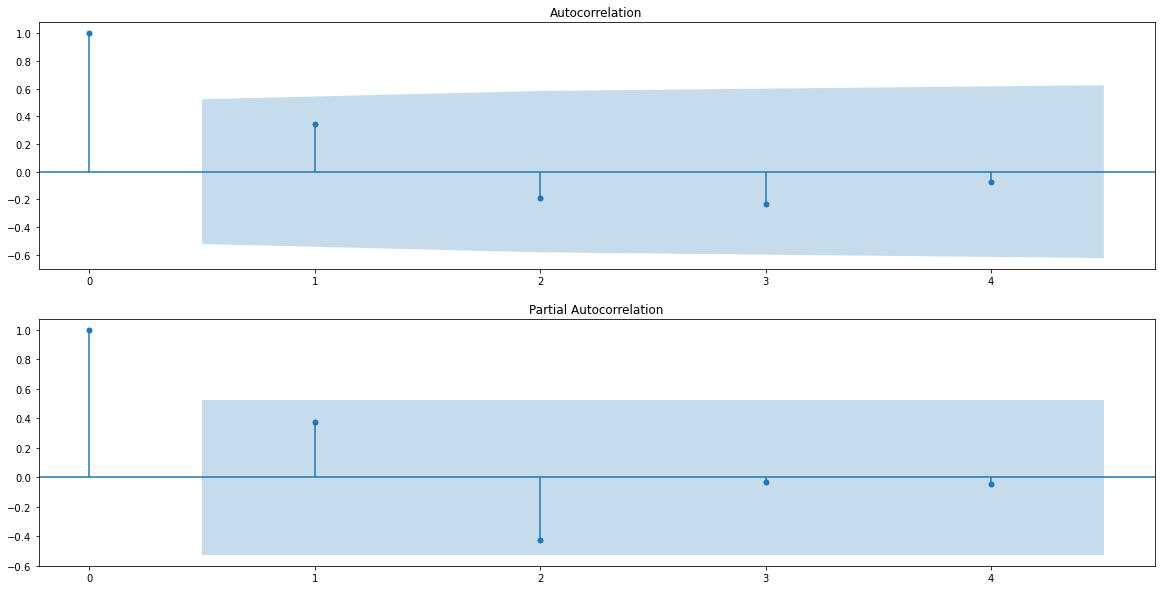

In [53]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(bal_diff, lags=4, ax=ax[0])
plot_pacf(bal_diff, lags=4, ax=ax[1])
plt.show()

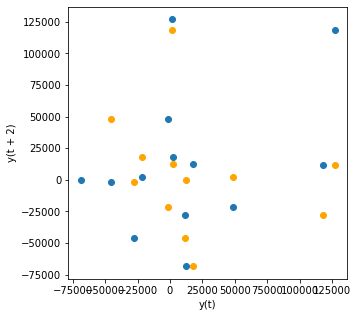

In [75]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(5, 5))
ax = lag_plot(bal_diff, lag=1)
ax = lag_plot(bal_diff, lag=2, c="orange")

plt.show()

CONTROLLARE I VALORI DI P E Q CHE DEVONO ESSERE IN CORRISPONDENZA
DEL VALORE DI ADFULLER FATTO SOPRA!!!

In [76]:
from statsmodels.tsa.arima.model import ARIMA

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-3
for p in range(3):
    # Loop over q values from 0-3
    for q in range(3):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(bal2["count"].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic
8,2,2,370.447681,373.642968,744.090649
2,0,2,369.982016,371.899188,741.881203
7,2,1,357.870775,360.427005,718.29778
4,1,1,352.163414,354.080586,706.243999
1,0,1,350.201078,351.479193,701.680271
6,2,0,349.809726,351.726898,701.536624
5,1,2,349.143245,351.699474,700.842719
0,0,0,346.926995,347.566052,694.493047
3,1,0,346.679935,347.95805,694.637985


In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(bal2, order=(1,1,0), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35903D+00    |proj g|=  6.64343D-01

At iterate    5    f=  1.92131D+00    |proj g|=  1.23140D-02

At iterate   10    f=  1.90659D+00    |proj g|=  6.11383D-04

At iterate   15    f=  1.90444D+00    |proj g|=  2.60358D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     22      1     0     0   4.764D-06   1.720D+00
  F =   1.7201153565395506     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                   15
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -25.802
Date:                            Mon, 16 May 2022   AIC                             55.603
Time:                                    22:59:05   BIC                             52.990
Sample:                                         0   HQIC                            50.137
                                             - 15                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.473      2.114      0.035       0.073       1.927
sigma2      1.936e+09   8.14e-13   2.38e+21      0.000    1.94e+09    1.94e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.16   Prob(JB):                         0.85
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         1.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+40. Standard errors may be unstable.
"""

In [78]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 864x576 with 0 Axes>

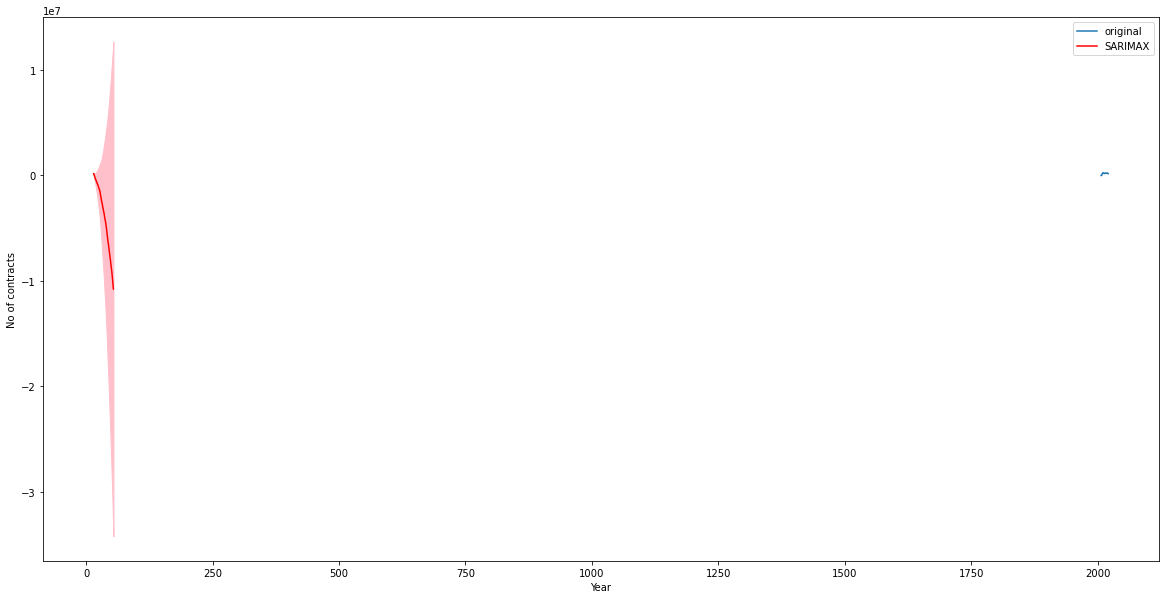

In [79]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=40)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(bal2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index, 
                 lower,upper,
                 color='pink')
plt.xlabel('Year')
plt.ylabel('No of contracts')
plt.legend()
plt.show()